# Sprint 12

In [1]:
import numpy as np
import pandas as pd

# ログ表示
class Log:
    # 表示ログレベル
    Loglevel = 0
    def logLevelset(level):
        # 表示ログレベルの設定
        Log.Loglevel = level
    def log_print(level, std, *variable):
        if(Log.Loglevel >= level):
            if(len(variable) == 0):
                print(std)
            else:
                for i in range(len(variable)):
                    index = std.find("}") + 1
                    # 改行なし表示
                    print(std[:index].format(variable[i]), end='')
                    # 表示した分を削除
                    std = std.replace(std[:index], "", 1)
                # 改行表示
                print(std)

In [120]:
Log.logLevelset(2)

# 1.Sprint10のスクラッチ

In [3]:
class Scratch1dCNNClassifier:
    """
    シンプルな三層ニューラルネットワーク分類器

    Parameters
    ----------

    Attributes
    ----------
    """
    def __init__(self, verbose=True, lr=1e-4, num_epoch=2000, batch_size=10, sigma=1e-4, n_nodes1=10, n_nodes2=5, n_output=1):
        self.verbose = verbose
        self.lr = lr
        self.num_epoch = num_epoch # epoch回数
        self.batch_size = batch_size # バッチサイズ
        self.sigma = sigma
        self.n_features = 0
        self.n_nodes1 = n_nodes1 # 1層目のノード数
        self.n_nodes2 = n_nodes2 # 2層目のノード数
        self.n_output = n_output # 出力数（3層目のノード数）
        self.cost = []
        
        # レイヤーのインスタンス
        self.FC1 = None
        self.FC2 = None
        self.FC3 = None
        self.activation1 = None
        self.activation2 = None
        self.activation3 = None
    
    def fit(self, X, y, X_val=None, y_val=None):
        if self.verbose:
            #verboseをTrueにした際は学習過程などを出力する
            print()
        
        # array変換
        X = np.array(X)
        y = np.array(y)
        
        # ミニバッチ生成
        get_mini_batch = GetMiniBatch(X, y, batch_size=10)
                
        """
        初期化処理
        """
        self.n_features = X.shape[1]
        
        optimizer = SGD(self.lr)   
        
        
        self.FC1 = FC(self.n_features, self.n_nodes1, SimpleInitializer(self.sigma), optimizer)
        self.activation1 = Tanh()
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, SimpleInitializer(self.sigma), optimizer)
        self.activation2 = Tanh()
        self.FC3 = FC(self.n_nodes2, self.n_output, SimpleInitializer(self.sigma), optimizer)
        self.activation3 = Identity()
        
        # エポック数分繰り返す
        for epoch in range(self.num_epoch):
            #print(epoch)
            for i, (mini_X, mini_y) in enumerate(get_mini_batch):
                """
                フォワードプロパゲーション
                """
                A1 = self.FC1.forward(X)
                Z1 = self.activation1.forward(A1)
                A2 = self.FC2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                A3 = self.FC3.forward(Z2)
                Z3 = self.activation3.forward(A3)
                
                """
                フォワードプロパゲーション
                """
                dA3 = self.activation3.backward(Z3, y) # 交差エントロピー誤差とソフトマックスを合わせている
                dZ2 = self.FC3.backward(dA3)
                dA2 = self.activation2.backward(dZ2)
                dZ1 = self.FC2.backward(dA2)
                dA1 = self.activation1.backward(dZ1)
                dZ0 = self.FC1.backward(dA1) # dZ0は使用しない
                
            # 平均二乗誤差
            loss = MSE.calculation(dA3)
            self.cost.append(loss)
            
    def predict(self, X):
        # array変換
        X = np.array(X)
        
        get_mini_batch = GetMiniBatch(X, X, batch_size=10)
        
        for i, (mini_X, mini_y) in enumerate(get_mini_batch):
            A1 = self.FC1.forward(X)
            Z1 = self.activation1.forward(A1)
            A2 = self.FC2.forward(Z1)
            Z2 = self.activation2.forward(A2)
            A3 = self.FC3.forward(Z2)
            Z3 = self.activation3.forward(A3)
            
        return Z3

In [4]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(n_nodes1, n_nodes2)
        Log.log_print(1, "self.W.shape{}", self.W.shape, self)
        Log.log_print(2, "self.W{}", self.W, self)
        self.B = initializer.B(n_nodes2)
        Log.log_print(1, "self.B.shape{}", self.B.shape, self)
        Log.log_print(2, "self.B{}", self.B, self)   
        self.forward_x = 0
        self.dZ = 0
        self.dA = 0
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """
        self.forward_x = X.copy()
        Log.log_print(2, "self.forward_x{}", self.forward_x, self)
        Log.log_print(1, "self.forward_x.shape{}", self.forward_x.shape, self)
        A = np.dot(X, self.W) + self.B
        Log.log_print(1, "A.shape{}", A.shape, self)
        Log.log_print(2, "A{}", A, self)
        return A
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        Log.log_print(1, "更新前", obj=self)
        Log.log_print(1, "self.B{}", self.B.shape, self)
        Log.log_print(1, "self.W{}", self.W.shape, self)
        
        self.dA = dA
        Log.log_print(1, "self.dA.shape{}", self.dA.shape, self)
        
        self.dZ = np.dot(dA, self.W.T)
        Log.log_print(1, "self.dZ.shape{}", self.dZ.shape, self)
        
        Log.log_print(2, "self.dZ{}", self.dZ)
        Log.log_print(1, "self.dZ.shape{}", self.dZ.shape, self)
        
        # 更新
        self.optimizer.update(self)
        
        Log.log_print(1, "更新後", obj=self)
        Log.log_print(1, "self.B{}{}", (self.B.shape, self.B), self)
        Log.log_print(1, "self.W{}", self.W.shape, self)
        
        return self.dZ

In [5]:
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    function : std
      初期関数のモード
    """
    def __init__(self, sigma):
        self.sigma = sigma
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        B = self.sigma * np.random.randn(1, n_nodes2)
        return B

In [6]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス

        Returns
        ----------
        layer : 更新後の層のインスタンス
        """
        layer.W = layer.W - self.lr*np.dot(layer.forward_x.T, layer.dA) / layer.dA.shape[0]
        layer.B = layer.B - self.lr*np.mean(layer.dA, axis=0)[np.newaxis,:]
        
        Log.log_print(1, "layer.W.shape{}", layer.W.shape, self)
        Log.log_print(2, "layer.W{}", layer.W, self)
        Log.log_print(1, "layer.B.shape{}", layer.B.shape, self)
        Log.log_print(2, "layer.B{}", layer.B, self)
        
        #return layer

In [7]:
class Tanh:
    def __init__(self):
        self.A = 0
        
    def forward(self, A):
        self.A = A
        return np.tanh(A)
    
    def backward(self, dZ):
        dA = dZ *(1 - np.tanh(self.A)**2)
        Log.log_print(1, "dA.shape{}{}", (dA.shape, dA), self)
        Log.log_print(2, "dA{}", dA, self)
        return dA

In [8]:
class Identity:
    def __init__(self):
        pass
    
    def forward(self, A):
        return A
    
    def backward(self, Yhat, Y):
        return Yhat - Y

In [9]:
class MSE:
    @classmethod
    def calculation(self, loss):
        return np.mean((loss)**2) / 2

In [10]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    y : 次の形のndarray, shape (n_samples, 1)または(n_samples,)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード

    Retruns
    ----------
    for文で呼び出すと以下の2つを返す。最後のイテレーションでは、バッチサイズより小さいこともある。
    mini_X : 次の形のndarray, shape (batch_size, n_features)
      学習データのミニバッチ
    mini_y : 次の形のndarray, shape (batch_size, 1)または(batch_size,)
      正解値のミニバッチ
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        # ランダムに並べ換える
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._counter = 0
        # イテレーション数を計算する
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        # len()が使われたときの処理
        return self._stop

    def __iter__(self):
        return self

    def __next__(self):
        # for文で呼ばれた際のループごとの処理
        if self._counter >= self._stop:
            # 最後まで進んだら終了
            self._counter = 0
            raise StopIteration()

        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

In [11]:
class DropOut:
    def __init__(self, P):
        self.P = 1 - P # 生存率
        self.mask = None
        
    def forward(self, X):
        self.mask = np.random.rand(*X.shape) > self.P
        return X*self.mask
    
    def backward(self, X):
        return X*self.mask

# 2. データセットの用意

In [12]:
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split

# 保存先を指定
mnist_dir = "./mnist_data/"

# MNISTの読み込み
mnist = fetch_mldata('MNIST original', data_home=mnist_dir)
# trainとtestに分割する
X_train, X_test, y_train, y_test = train_test_split(mnist.data, mnist.target, test_size=0.14285, shuffle=False)
# ラベルをint型にしておく
y_train = y_train.astype(np.int)
y_test = y_test.astype(np.int)

/home/hiro/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
/home/hiro/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


## データセットの確認

In [13]:
print(X_train.shape) # (60000, 784)
print(X_test.shape) # (10000, 784)
print(X_train[0].dtype) # uint8
print(X_train[0])

(60000, 784)
(10000, 784)
uint8
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0  51 159 253 159  50   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0  48 238 252 252 252 237   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0  54 227 253 252 239 233 252  57   6   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0  10  60 224 252 253 252 202  84 252
 253 122   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0 163 252 252 25

## 画像データの可視化

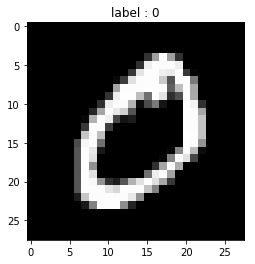

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
index = 0
image = X_train[index].reshape(28,28)
# X_train[index]: (784,)
# image: (28, 28)
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()

## 前処理
1. 画素値を0〜1の範囲に正規化する。<br>
2. 正解ラベルをOneHot-Encoder

In [15]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

1.0
0.0


In [16]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

(60000,)
(60000, 10)
float64


## SimpleConv1d 作成

In [26]:
class SimpleConv1d:
    def __init__(self, F, ir):
        #self.W = np.random.randint(1, 10, (F,)).astype(np.float)
        self.W = np.array([3,5,7]).astype(np.float)
        self.F = F
        self.forward_x = None
        self.B = 1
        self.ir = ir
        print("self.W", self.W)
        
    def forward(self, X):
        self.forward_x = X.copy()
        result = []

        for i in range(len(x) - self.F + 1):
            result.append(np.sum(self.W*X[i:i+self.F]))
        
        result = np.array(result) + self.B
        
        Log.log_print(1, "result.shape:{}", result.shape, self)
        Log.log_print(2, "result:{}", result, self)
        
        Log.log_print(1, "self.W.shape:{}", self.W.shape, self)
        Log.log_print(2, "self.W:{}", self.W, self)
        
        return result
    
    def backward(self, delta):
        # バイアス
        # 勾配
        dB = np.sum(delta)
        
        Log.log_print(1, "dB.shape:{}", dB.shape, self)
        Log.log_print(2, "dB:{}", dB, self)
        
        # 更新
        self.B -= self.ir*dB.astype(np.float)
        
        Log.log_print(1, "self.B.shape:{}", self.B.shape, self)
        Log.log_print(2, "self.B:{}", self.B , self)
        
        # 出力
        #　勾配
        dZ = []
        Nout = len(delta)
        
        for i in range(len(self.forward_x)):
            if(i == 0):
                Log.log_print(1, "delta[0].shape:{}", delta[0].shape, self)
                Log.log_print(2, "delta:{}", delta[0], self)
                Log.log_print(1, "self.W[-1].shape:{}", self.W[-1].shape, self)
                Log.log_print(2, "self.W[-1]:{}", self.W[-1], self)
                
                dZ.append(delta[0]*self.W[0])
            
            elif(i == (len(self.forward_x) -1)):
                
                Log.log_print(1, "delta[-1].shape:{}", delta[-1].shape, self)
                Log.log_print(2, "delta[-1]:{}", delta[-1], self)
                Log.log_print(1, "self.W[-1].shape:{}", self.W[-1].shape, self)
                Log.log_print(2, "self.W[-1]:{}", self.W[-1], self)
                
                dZ.append(delta[-1]*self.W[-1])
            else:
                
                Log.log_print(1, "delta.shape:{}", delta.shape, self)
                Log.log_print(2, "delta:{}", delta, self)
                Log.log_print(1, "self.W[i-1:i-1+Nout].shape:{}", self.W[i-1:i-1+Nout].shape, self)
                Log.log_print(2, "self.W[i-1:i-1+Nout]:{}", self.W[i-1:i-1+Nout], self)
                
                dZ.append(np.sum(delta*self.W[i-1:i-1+Nout]))
                
        dZ = np.array(dZ)
        
        Log.log_print(1, "dZ.shape:{}", dZ.shape, self)
        Log.log_print(2, "dZ:{}", dZ, self)
        
        # 重み
        #　勾配
        dW = []
        for i in range(self.F):
            
            Log.log_print(1, "delta.shape:{}", delta.shape, self)
            Log.log_print(2, "delta:{}", delta, self)
            Log.log_print(1, "self.forward_x[i:i+Nout].shape:{}", self.forward_x[i:i+Nout].shape, self)
            Log.log_print(2, "self.forward_x[i:i+Nout]:{}", self.forward_x[i:i+Nout], self)
            
            dW.append(np.sum(delta*self.forward_x[i:i+Nout]))
        
        dW = np.array(dW)
        print("dW", dW)
        
        # 更新
        self.W -= self.ir*dW
        
        Log.log_print(1, "self.dW.shape:{}", dW.shape, self)
        Log.log_print(2, "self.dW:{}", dW, self)
        
        return dZ

## 実行結果

In [122]:
x = np.array([1,2,3,4])
w = np.array([3, 5, 7])
b = np.array([1])

In [123]:
a = np.array([10, 20])
testinstance = SimpleConv1d(3, 0.1)
testinstance.forward(x)
testinstance.backward(a)

self.W [3. 5. 7.]
result.shape:(2,)
result:[35. 50.]
self.W.shape:(3,)
self.W:[3. 5. 7.]
dB.shape:()
dB:30
self.B.shape:()
self.B:-2.0
delta[0].shape:()
delta:10
self.W[-1].shape:()
self.W[-1]:7.0
delta.shape:(2,)
delta:[10 20]
self.W[i-1:i-1+Nout].shape:(2,)
self.W[i-1:i-1+Nout]:[3. 5.]
delta.shape:(2,)
delta:[10 20]
self.W[i-1:i-1+Nout].shape:(2,)
self.W[i-1:i-1+Nout]:[5. 7.]
delta[-1].shape:()
delta[-1]:20
self.W[-1].shape:()
self.W[-1]:7.0
dZ.shape:(4,)
dZ:[ 30. 130. 190. 140.]
delta.shape:(2,)
delta:[10 20]
self.forward_x[i:i+Nout].shape:(2,)
self.forward_x[i:i+Nout]:[1 2]
delta.shape:(2,)
delta:[10 20]
self.forward_x[i:i+Nout].shape:(2,)
self.forward_x[i:i+Nout]:[2 3]
delta.shape:(2,)
delta:[10 20]
self.forward_x[i:i+Nout].shape:(2,)
self.forward_x[i:i+Nout]:[3 4]
dW [ 50  80 110]
self.dW.shape:(3,)
self.dW:[ 50  80 110]


array([ 30., 130., 190., 140.])

In [27]:
a = np.array([10, 20])
testinstance = SimpleConv1d(3, 0.1)
testinstance.forward(x)
testinstance.backward(a)

self.W [3. 5. 7.]
dW [ 50  80 110]


array([ 30., 130., 190., 140.])

In [48]:
np.pad(a, 2, mode="constant")

array([ 0,  0, 10, 20,  0,  0])

In [30]:
test = np.array([
    [1, 2], [1, 2]
])

In [31]:
test

array([[1, 2],
       [1, 2]])

In [43]:
np.pad(test, (1), "constant")


array([[0, 0, 0, 0],
       [0, 1, 2, 0],
       [0, 1, 2, 0],
       [0, 0, 0, 0]])

In [49]:
class SimpleConv1d:
    def __init__(self, F, ir):
        #self.W = np.random.randint(1, 10, (F,)).astype(np.float)
        self.W = np.array([3,5,7]).astype(np.float)
        self.F = F
        self.forward_x = None
        self.B = 1
        self.ir = ir
        print("self.W", self.W)
        
    def forward(self, X):
        self.forward_x = X.copy()
        result = []

        for i in range(len(x) - self.F + 1):
            result.append(np.sum(self.W*X[i:i+self.F]))
        
        result = np.array(result) + self.B
        
        Log.log_print(1, "result.shape:{}", result.shape, self)
        Log.log_print(2, "result:{}", result, self)
        
        Log.log_print(1, "self.W.shape:{}", self.W.shape, self)
        Log.log_print(2, "self.W:{}", self.W, self)
        
        return result
    
    def backward(self, delta):
        # バイアス
        # 勾配
        dB = np.sum(delta)
        
        Log.log_print(1, "dB.shape:{}", dB.shape, self)
        Log.log_print(2, "dB:{}", dB, self)
        
        # 更新
        self.B -= self.ir*dB.astype(np.float)
        
        Log.log_print(1, "self.B.shape:{}", self.B.shape, self)
        Log.log_print(2, "self.B:{}", self.B , self)
        
        # 出力
        #　勾配
        dZ = []
        Nout = len(delta)
        
        for i in range(len(self.forward_x)):
            if(i == 0):
                Log.log_print(1, "delta[0].shape:{}", delta[0].shape, self)
                Log.log_print(2, "delta:{}", delta[0], self)
                Log.log_print(1, "self.W[-1].shape:{}", self.W[-1].shape, self)
                Log.log_print(2, "self.W[-1]:{}", self.W[-1], self)
                
                dZ.append(delta[0]*self.W[0])
            
            elif(i == (len(self.forward_x) -1)):
                
                Log.log_print(1, "delta[-1].shape:{}", delta[-1].shape, self)
                Log.log_print(2, "delta[-1]:{}", delta[-1], self)
                Log.log_print(1, "self.W[-1].shape:{}", self.W[-1].shape, self)
                Log.log_print(2, "self.W[-1]:{}", self.W[-1], self)
                
                dZ.append(delta[-1]*self.W[-1])
            else:
                
                Log.log_print(1, "delta.shape:{}", delta.shape, self)
                Log.log_print(2, "delta:{}", delta, self)
                Log.log_print(1, "self.W[i-1:i-1+Nout].shape:{}", self.W[i-1:i-1+Nout].shape, self)
                Log.log_print(2, "self.W[i-1:i-1+Nout]:{}", self.W[i-1:i-1+Nout], self)
                
                dZ.append(np.sum(delta*self.W[i-1:i-1+Nout]))
                
        dZ = np.array(dZ)
        
        Log.log_print(1, "dZ.shape:{}", dZ.shape, self)
        Log.log_print(2, "dZ:{}", dZ, self)
        
        # 重み
        #　勾配
        dW = []
        for i in range(self.F):
            
            Log.log_print(1, "delta.shape:{}", delta.shape, self)
            Log.log_print(2, "delta:{}", delta, self)
            Log.log_print(1, "self.forward_x[i:i+Nout].shape:{}", self.forward_x[i:i+Nout].shape, self)
            Log.log_print(2, "self.forward_x[i:i+Nout]:{}", self.forward_x[i:i+Nout], self)
            
            dW.append(np.sum(delta*self.forward_x[i:i+Nout]))
        
        dW = np.array(dW)
        print("dW", dW)
        
        # 更新
        self.W -= self.ir*dW
        
        Log.log_print(1, "self.dW.shape:{}", dW.shape, self)
        Log.log_print(2, "self.dW:{}", dW, self)
        
        return dZ

In [125]:
x = np.array([[1, 2, 3, 4], [2, 3, 4, 5]]) # shape(2, 4)で、（入力チャンネル数、特徴量数）である。
w = np.ones((3, 2, 3)) # 例の簡略化のため全て1とする。(出力チャンネル数、入力チャンネル数、フィルタサイズ)である。
b = np.array([1, 2, 3]) 

In [54]:
x.shape[0]

2

In [55]:
x.shape[1] - 3 + 1

2

In [56]:
np.where

range(0, 1)

In [63]:
a  = np.array(list(range(0,2)))
a

TypeError: 'range' object is not callable

In [66]:
np.arange(0,3)

array([0, 1, 2])

In [86]:
W = np.ones((3, 2, 3))

In [67]:
index = []
F=3
for i in range(x.shape[1] - F + 1):
    index.append(np.arange(i, i+F))

In [132]:
index = np.vstack(index)

In [114]:
newx = []
for i in range(2):
    for j in range(2):
        newx.append(x[i][index[j]])

In [117]:
t = np.vstack(newx)

In [154]:
x=np.array([[11,12,13,14],[12,13,14,15]])

In [135]:
index[:]

array([[0, 1, 2],
       [1, 2, 3]])

In [158]:
x[:,index[0]]

array([[11, 12, 13],
       [12, 13, 14]])

In [148]:
z=x[0]
z[index[0]]

array([1, 2, 3])

In [161]:
index[0]

array([0, 1, 2])

In [160]:
x[:,index[0]]

array([[11, 12, 13],
       [12, 13, 14]])

In [107]:
x = np.array([[1, 2, 3, 4],
       [2, 3, 4, 5]])
x

array([[1, 2, 3, 4],
       [2, 3, 4, 5]])

In [108]:
x = np.matlib.repmat(x,F,1)
x.shape

(6, 4)

In [103]:
t[np.newaxis,:,:]

array([[[1, 2, 3, 4],
        [2, 3, 4, 5]]])

In [81]:
x.shape

(4, 4)

In [118]:
np.dot(t[np.newaxis,:,:], W.T)

ValueError: shapes (1,4,3) and (3,2,3) not aligned: 3 (dim 2) != 2 (dim 1)

In [89]:
test

array([[[1, 2, 3, 4],
        [2, 3, 4, 5],
        [1, 2, 3, 4],
        [2, 3, 4, 5]]])

In [119]:
t[np.newaxis,:,:]

array([[[1, 2, 3],
        [2, 3, 4],
        [2, 3, 4],
        [3, 4, 5]]])

In [128]:
w[0].shape

(2, 3)

In [130]:
index

[array([0, 1, 2]), array([1, 2, 3])]